Iterative alpha-(de)Blending: A Minimalist Deterministic Diffusion Model
https://github.com/tchambon/IADB/blob/main/README.md

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np 
from diffusers import UNet2DModel

In [4]:
device = torch.device('mps')

transform = transforms.Compose([
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(
    '~/ML/data/', 
    train=True, 
    download=True,
    transform=transform,
)
train_dataset.data.to(device)
train_dataset.targets.to(device)


test_dataset = torchvision.datasets.MNIST(
    '~/ML/data/',
    train=False,
    download=True,
    transform=transform
)
test_dataset.data.to(device)
test_dataset.targets.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True 
)

In [156]:
def get_model():
    block_out_channels=(32, 32, 64)
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D", 
        "DownBlock2D", 
    )
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D", 
        "UpBlock2D"  
    )
    return UNet2DModel(block_out_channels=block_out_channels,out_channels=1, in_channels=1, up_block_types=up_block_types, down_block_types=down_block_types, add_attention=True)


network = get_model().to(device)
optimizer = optim.Adam(network.parameters())

In [77]:
train_log_batch = 10
def train(epoch):
    network.train()
    total_loss = 0
    total_loss_last_log = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        x0 = torch.randn([28, 28], device=device)
        x1 = data.to(device)
        alpha = torch.rand(batch_size, device=device).view(-1, 1, 1, 1)
        optimizer.zero_grad()
        
        x_alpha = x0 * (1 - alpha) + x1 * alpha
        
        loss = (((network.forward(x_alpha, alpha.view(-1))['sample']) - (x1 - x0))**2).sum()
        
        loss.backward()
        optimizer.step()
        
        if total_loss == 0:
            total_loss = loss.item() / target.shape[0]
        else:
            total_loss = 0.95 * total_loss + 0.05 * loss.item() / target.shape[0]
        total_loss_last_log += loss.item()

        if (batch_idx+1) % train_log_batch == 0:
            print("\tTrain Batch: {} Loss: {:.6f} {:.6f}".format(batch_idx+1, total_loss, total_loss_last_log / (train_log_batch * target.shape[0])))
            total_loss_last_log = 0
            
    print('Train Epoch: {} Loss: {:.6f}\n'.format(epoch, total_loss))


In [158]:
train(1)

	Train Batch: 10 Loss: 99.718675 92.969200
	Train Batch: 20 Loss: 98.816348 97.250555
	Train Batch: 30 Loss: 98.417943 97.524300
	Train Batch: 40 Loss: 97.822219 97.640760
	Train Batch: 50 Loss: 96.356080 94.446642
	Train Batch: 60 Loss: 96.273435 96.094439
	Train Batch: 70 Loss: 95.397868 93.841364
	Train Batch: 80 Loss: 94.571590 93.366562
	Train Batch: 90 Loss: 93.361398 91.610486
	Train Batch: 100 Loss: 92.599235 91.737603
	Train Batch: 110 Loss: 93.446175 94.256180
	Train Batch: 120 Loss: 93.310806 92.712450
	Train Batch: 130 Loss: 91.978691 89.863063
	Train Batch: 140 Loss: 91.061658 89.820190
	Train Batch: 150 Loss: 91.259499 91.347807
	Train Batch: 160 Loss: 91.213802 91.237708
	Train Batch: 170 Loss: 91.108533 91.285049
	Train Batch: 180 Loss: 91.647539 92.432749
	Train Batch: 190 Loss: 90.703021 88.975194
	Train Batch: 200 Loss: 92.508963 94.472401
	Train Batch: 210 Loss: 92.592471 92.791071
	Train Batch: 220 Loss: 90.480292 87.361942
	Train Batch: 230 Loss: 91.674188 93.3919

In [159]:
@torch.no_grad()
def generate(steps=100, sample_every = 10):
    network.eval()     
    x0 = torch.randn([28, 28]).to(device)
    x_t = x0
    samples = []
    for step in range(steps):
        if step % sample_every == 0: 
            samples.append(x_t.view(28, 28))
           
        alpha_t   = step / steps

        diff  = network.forward(x_t.view(1, 1, 28, 28), torch.tensor(alpha_t, device=device))['sample']
        x_t   = x_t + diff * 1/steps
    
    samples.append(x_t.view(28, 28))
    return x_t.view(28, 28), samples


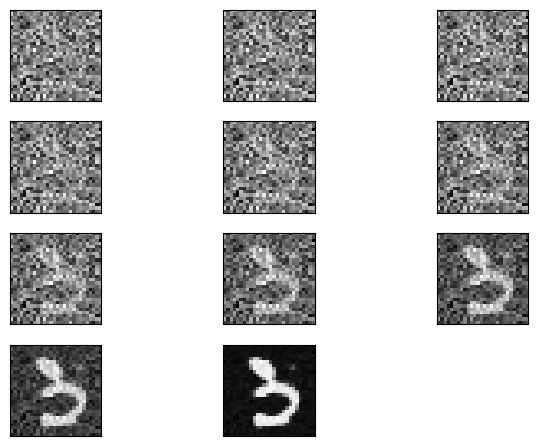

In [160]:
# Visualize the reconstruction
import matplotlib.pyplot as plt
import math

def plot_images(n, data):
    fig = plt.figure()
    ncols = 3
    nrows = math.ceil(n/ncols)
    for i in range(n):
      plt.subplot(nrows, ncols,i+1)
      plt.tight_layout()
      plt.imshow(data[i].detach().cpu(), cmap='gray', interpolation='none')
      plt.xticks([])
      plt.yticks([])

      fig

final, samples = generate(40, 4)
#samples = [generate(100, 10000)[0] for _ in range(9)]
plot_images(len(samples), samples)

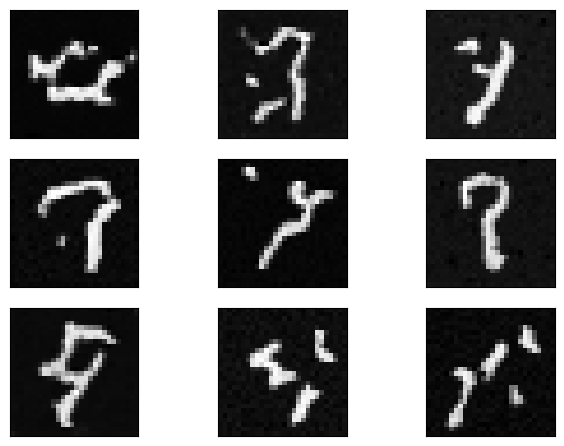

In [163]:
samples = [generate(40, 10000)[0] for _ in range(9)]
plot_images(len(samples), samples)